In [1]:
!pip install -U mxnet-cu101==1.6.0  # updating mxnet to at least v1.6

Looking in links: https://d2l.ai/whl.html
     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 710.5MB 24kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
!wget https://lilablobssc.blob.core.windows.net/cvwc2019/train/atrw_detection_train.tar.gz
!wget https://lilablobssc.blob.core.windows.net/cvwc2019/train/atrw_anno_detection_train.tar.gz

--2020-08-10 00:44:22--  https://lilablobssc.blob.core.windows.net/cvwc2019/train/atrw_detection_train.tar.gz
Resolving lilablobssc.blob.core.windows.net (lilablobssc.blob.core.windows.net)... 52.239.159.84
Connecting to lilablobssc.blob.core.windows.net (lilablobssc.blob.core.windows.net)|52.239.159.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2288778168 (2.1G) [application/gzip]
Saving to: ‘atrw_detection_train.tar.gz’

atrw_detection_trai 100%[===================>]   2.13G  20.6MB/s    in 1m 46s  

2020-08-10 00:46:09 (20.6 MB/s) - ‘atrw_detection_train.tar.gz’ saved [2288778168/2288778168]

--2020-08-10 00:46:10--  https://lilablobssc.blob.core.windows.net/cvwc2019/train/atrw_anno_detection_train.tar.gz
Resolving lilablobssc.blob.core.windows.net (lilablobssc.blob.core.windows.net)... 52.239.159.84
Connecting to lilablobssc.blob.core.windows.net (lilablobssc.blob.core.windows.net)|52.239.159.84|:443... connected.
HTTP request sent, awaiting response.

In [4]:
!tar --extract --file /content/atrw_detection_train.tar.gz
!tar --extract --file /content/atrw_anno_detection_train.tar.gz

In [18]:
!nvidia-smi

Mon Aug 10 01:02:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from gluoncv.data.base import VisionDataset
import os
import warnings
import glob
import logging
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import mxnet as mx
from mxnet.gluon import Trainer
from mxnet.gluon.data.vision import transforms
from TigerData import *
from TigerLoss import *
from Metrics import Accumulator,F1Score
from Tigernet import *
from TigerSSD import *
from gluoncv.data.transforms.bbox import *
import matplotlib.pyplot as plt
from mxnet import np,nd
from mxnet.gluon.data import DataLoader
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from TigerData import *
from TigerLoss import *
from Metrics import Accumulator,F1Score
from google.colab import files
from Tigernet import *
from TigerSSD import *
npx.set_np()

In [2]:
root="/content/TigerDetect"
batch_size=4
train_data=data(True,root,batch_size)
test_data=data(False,root,batch_size)

device=mxnet.gpu(0)

model=TigerSSD(batch_size)
model.initialize(init=mxnet.init.Xavier(),ctx=device)
trainer=Trainer(model.collect_params(),'nag',{'learning_rate':0.1,'wd':0.0001})

lr_decay_epoch=[8,13,16,19]

num_epochs=20

print("Size of training data :",len(train_data))
print("Size of test data :",len(test_data))

Size of training data : 656
Size of test data : 69


In [3]:
for batch in train_data:
    x,y=batch[0].as_in_ctx(device),batch[1].as_in_ctx(device)
    break

In [4]:
a,c,b=model(x)

In [5]:
a.shape,c.shape,b.shape

((1, 119, 4), (4, 119, 2), (4, 476))

In [6]:
losses=LossBox(c.shape[0:2])

In [7]:
f1=F1Score()

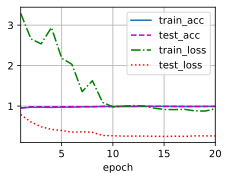

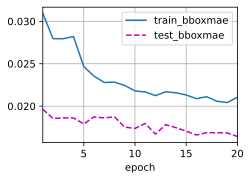

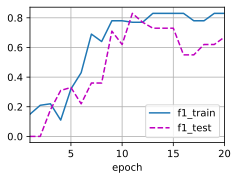

In [8]:
animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=['train_acc','test_acc','train_loss','test_loss'])
animator2 = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],legend=['train_bboxmae','test_bboxmae'])
f1animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=['f1_train','f1_test'])
for epoch in range(num_epochs):
    
    train_f1_score,test_f1_score=0,0
  
    if epoch in lr_decay_epoch:
       trainer.set_learning_rate(trainer.optimizer.lr/7)
    
    for data in train_data:
        image=data[0].as_in_ctx(device)
        label=data[1].as_in_ctx(device)
        
        with autograd.record():
            anchors,class_predictions,bbox_predictions=model(image)
            bbox_labels,bbox_masks,class_labels=npx.multibox_target(anchors,label,class_predictions.transpose(0,2,1))
            weight=np.ones(shape=bbox_labels.shape).as_in_ctx(device)
            weight=weight*bbox_masks
            weight=weight*5
            loss=(losses.calculate_loss(class_predictions,class_labels,bbox_predictions,bbox_labels,bbox_masks,1,weight)).sum()
      
        loss.backward()
        trainer.step(batch_size)

    class_acc_train=losses.evaluateclass(class_predictions,class_labels)
    
    bbox_mae_train=losses.evaluatebbox(bbox_predictions,bbox_labels,bbox_masks)
    class_p=(class_predictions.argmax(axis=-1)).reshape(-1)
    class_l=class_labels.reshape(-1)
    train_loss=loss.item()
    train_f1_score=f1((class_p,class_l))
     
    for data in test_data:
        image=data[0].as_in_ctx(device)
        label=data[1].as_in_ctx(device)
        anchors,class_predictions,bbox_predictions=model(image)
        bbox_labels,bbox_masks,class_labels=npx.multibox_target(anchors,label,class_predictions.transpose(0,2,1))
        weight=np.ones(shape=bbox_labels.shape).as_in_ctx(device)
        weight=weight*bbox_masks
        test_losses=(losses.calculate_loss(class_predictions,class_labels,bbox_predictions,bbox_labels,bbox_masks,0,weight)).sum()
        
    class_acc_test=losses.evaluateclass(class_predictions,class_labels)

    if class_acc_test>0.85:
       model.save_parameters('1ststagetest'+str(epoch)+str(class_acc_test))
    
    bbox_mae_test=losses.evaluatebbox(bbox_predictions,bbox_labels,bbox_masks)
    test_loss=test_losses.item()
    class_p=(class_predictions.argmax(axis=-1)).reshape(-1)
    class_l=class_labels.reshape(-1)
    test_f1_score=f1((class_p,class_l))

    if test_loss-train_loss>5:
       trainer.optimizer.wd=trainer.optimizer.wd*2
    

    animator2.add(epoch+1,(bbox_mae_train,bbox_mae_test))
    f1animator.add(epoch+1,(train_f1_score,test_f1_score))
    animator.add(epoch+1,(class_acc_train,class_acc_test,train_loss,test_loss))